## Zadanie domowe: Projektowanie filtru metodą okien

Zauważone w zadaniu z filtracją artefakty są efektem zastosowania filtru idealnego (wycięcia odpowiednich częstotliwości).
Aby je usunąć, należy filtr idealny w dziedzinie przestrzennej przemnożyć przez dwuwymiarowe okno (stworzone na podstawie jednowymiarowego).

1. Zdefiniuj rozmiar filtra (np. 21).

2. Stwórz okno np. Hamminga (`np.Hmming`) o zadanym rozmiarze.

3. Na podstawie tego okna stwórz okno dwuwymiarowe: $F = f^Tf$.
Można to zrealizować prostą instrukcją:
        hanning2d = np.outer(hanning, hanning)

4. Stwórz wzorcowy filtr idealny tak samo jak w poprzednim ćwiczeniu.
Jego rozmiar musi być taki sam jak zdefiniowany w punkcie pierwszym.

5. Generalna zasada jest taka, że należy obliczyć odwrotną transformatę Fouriera filtru idealnego.
Aby zagwarantować jednak dobrą lokalizację i symetryczność tworzonego filtru wykorzystuje się dodatkowe rotacje i przesunięcia.
```python
FilterFRot = np.rot90(np.fft.fftshift(np.rot90(FilterF, 2)), 2)
FilterFRot3 = np.dstack((FilterFRot, np.zeros(FilterFRot.shape)))
FilterFidft = cv2.idft(np.float32(FilterFRot3),
                flags=cv2.DFT_SCALE | cv2.DFT_COMPLEX_OUTPUT)
FilterFI = np.rot90(np.fft.fftshift(FilterFidft[:, :, 0]), 2)
```
6. Aby otrzymać poprawny filtr należy teraz pomnożyć dwuwymiarowe okno ze stworzonym filtrem idealnym w dziedzinie przestrzennej.

7. Stworzony filtr powinien zostać znowu przeniesiony do dziedziny częstotliwości.
Należy jednak rozszerzyć go tak, aby miał taki sam rozmiar jak filtrowany obraz.
Operację tę wykonaj tak samo jak w poprzednim ćwiczeniu (`cv2.copyMakeBorder`).
Oblicz transformatę Fouriera i wykonaj przesunięcie.
Następnie oblicz wartość bezwzględną (dzięki temu filtr nie będzie wpływał na fazę).
Wynikiem jest poprawiony filtr w dziedzinie częstotliwości.

8. Przeprowadź filtrację obrazu *lena.bmp* za pomocą zaprojektowanego filtra.
Wyświetl filtr, oraz wynik filtracji.
Do wyświetlenia filtru możesz użyć przestrzeń częstotliwości wygenerowaną w poprzednim zadaniu (*FSpaceRowsM* i *FSpaceColsM*).

In [39]:
import cv2
import os
import requests
from matplotlib import pyplot as plt
import numpy as np
import math

url = 'https://raw.githubusercontent.com/vision-agh/poc_sw/master/08_Fourier/'

fileNames = ["lena.bmp"]
for fileName in fileNames:
  if not os.path.exists(fileName):
      r = requests.get(url + fileName, allow_redirects=True)
      open(fileName, 'wb').write(r.content)

In [40]:
def show_all(images = [], vertical = False):
    def append_plot(ax, image):
        ax.imshow(image, 'gray')

    n = len(images)
    shorter_side = 10
    longer_side = 5 * len(images)

    if vertical:
        fig, axs = plt.subplots( n, 1 )
        fig.set_size_inches(shorter_side, longer_side)
    else:
        fig, axs = plt.subplots( 1, n )
        fig.set_size_inches(longer_side, shorter_side)


    if len(images) == 1:
        image = images[0]
        append_plot(axs, image)
    else:
        for i in range(len(images)):
            image = images[i]
            append_plot(axs[i], image)
    plt.show()

def open_image(path, gray = True):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY if gray else cv2.COLOR_BGR2RGB)
    return image

def get_fourier(image) :
    transformed = cv2.dft(
        np.float32(image), 
        flags = cv2.DFT_COMPLEX_OUTPUT
    )
    return np.fft.fftshift(transformed, [0,1])

image_lena = open_image("lena.bmp")

def reverse_fourier_2d(image, fourier = None):
    if fourier is None:
        fourier = get_fourier(image)
    inversed_fourier = np.fft.ifftshift(fourier, axes=[0,1])

    ifft = cv2.idft(inversed_fourier, flags = cv2.DFT_SCALE | cv2.DFT_COMPLEX_OUTPUT)
    img = cv2.magnitude(ifft[:, :, 0], ifft[:, :, 1])
    return np.round(img).astype('uint8')

def use_fourier_filter(image, filter):
    fourier = get_fourier(image)
    filter_f3 = np.repeat(filter[:,:, np.newaxis], 2, axis=2)
    return np.abs(reverse_fourier_2d(image, filter_f3 * fourier))


def plot_graph(FSpaceRowsM, FSpaceColsM, FilterF):
    figFilter = plt.figure()
    axsFilter = figFilter.add_subplot(projection='3d')
    axsFilter.plot_surface(FSpaceRowsM, FSpaceColsM, FilterF, rstride=1, cstride=1, cmap=plt.get_cmap('gray'), linewidth=0)
    figFilter.show()
    plt.show()

ideal filter:


C:\Users\xRamzes\AppData\Local\Temp\ipykernel_19272\257698596.py:59: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  figFilter.show()


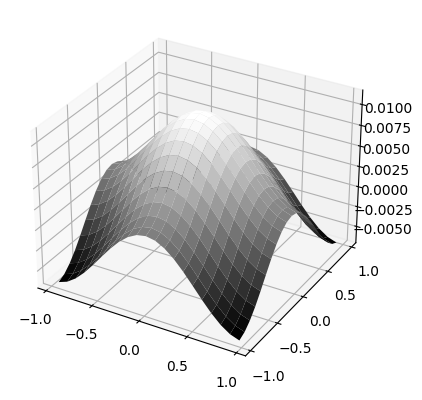

result filter:


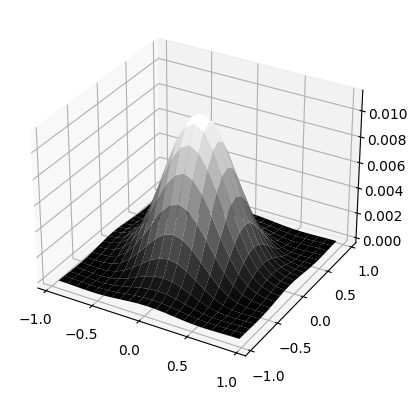

ideal filter:


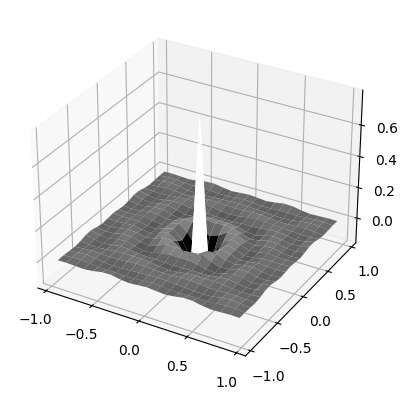

result filter:


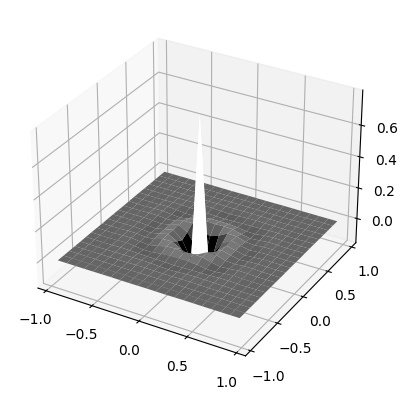

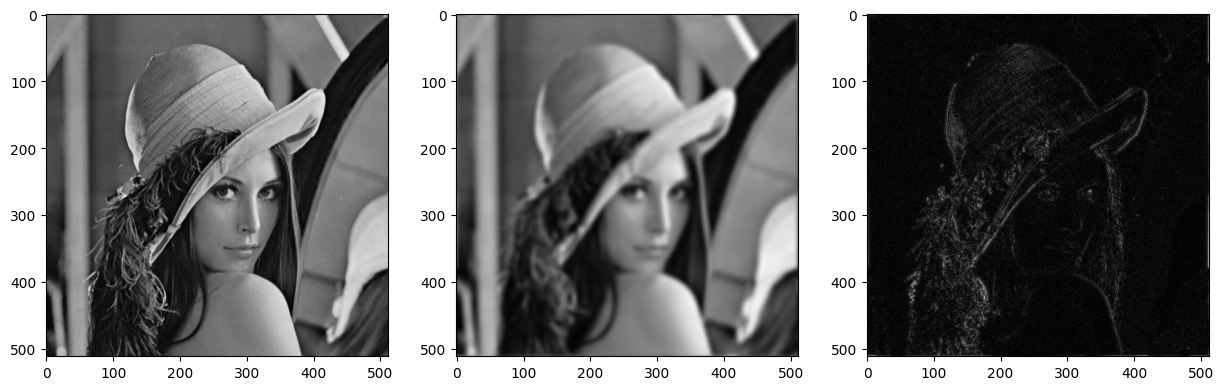

In [41]:
def window_method_filter(
    image,
    filter_condition = lambda x: x <= 0.1, 
    window_size = 21
):
    # Create hamming space
    window = np.hamming(window_size)
    window_2d = np.outer(window, window)

    # Prepare ideal filter
    FSpaceRows = 2 * np.fft.fftshift(np.fft.fftfreq(window_size))
    FSpaceRowsM = np.outer(FSpaceRows, np.ones([1, window_size]))
    FSpaceCols = 2 * np.fft.fftshift(np.fft.fftfreq(window_size))
    FSpaceColsM = np.outer(np.ones([1, window_size]), FSpaceCols)

    FreqR = np.sqrt(np.square(FSpaceRowsM) + np.square(FSpaceColsM))
    # Setup a condition
    FilterF = filter_condition(FreqR)

    # Setup to inverse fourier
    FilterFRot = np.rot90(np.fft.fftshift(np.rot90(FilterF, 2)), 2)
    FilterFRot3 = np.dstack((
        FilterFRot, 
        np.zeros(FilterFRot.shape)
    ))

    FilterFidft = cv2.idft(
        np.float32(FilterFRot3),
        flags=cv2.DFT_SCALE | cv2.DFT_COMPLEX_OUTPUT
    )

    FilterFI = np.rot90(np.fft.fftshift(FilterFidft[:, :, 0]), 2)

    result_filter = window_2d * FilterFI

    # Add padding to window
    down = (image.shape[1] - window_size)
    right = (image.shape[0] - window_size)

    padding = cv2.copyMakeBorder(
        result_filter, 
        down // 2, 
        down - down // 2, 
        right // 2, 
        right - right // 2, 
        cv2.BORDER_CONSTANT,
        value=0 
    )
    print("ideal filter:")
    plot_graph(FSpaceRowsM, FSpaceColsM, FilterFI)
    print("result filter:")
    plot_graph(FSpaceRowsM, FSpaceColsM, result_filter)

    # Fourier Transform & shift
    fourier = np.abs(get_fourier(padding))

    result = cv2.magnitude(fourier[:, :, 0], fourier[:, :, 1])

    return use_fourier_filter(image, result)

show_all([
    image_lena,
    window_method_filter(image_lena),
    window_method_filter(image_lena, lambda freq_r: freq_r >= 0.5),
])


ideal filter:


C:\Users\xRamzes\AppData\Local\Temp\ipykernel_19272\257698596.py:59: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  figFilter.show()


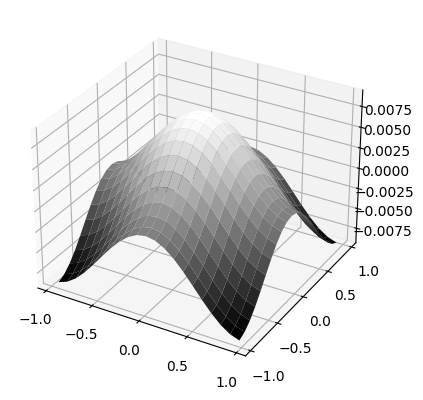

result filter:


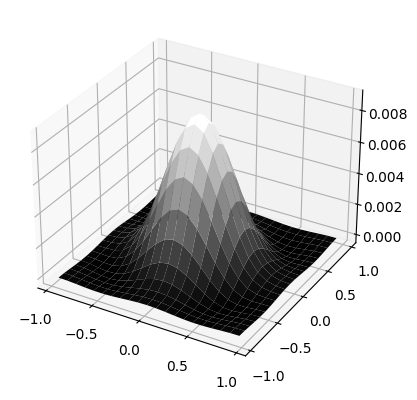

ideal filter:


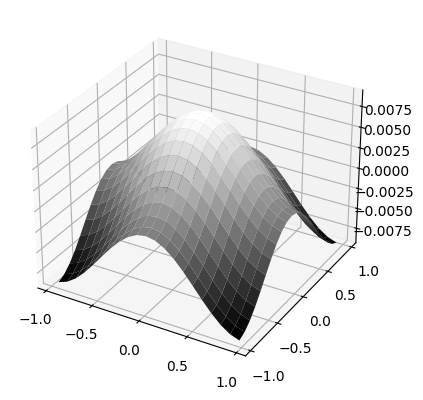

result filter:


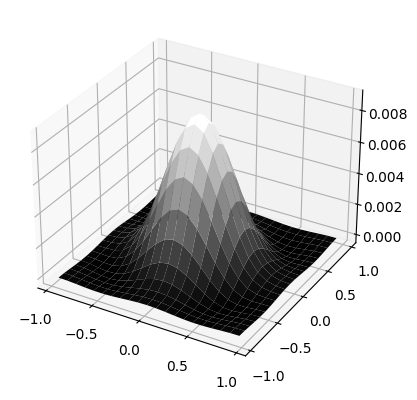

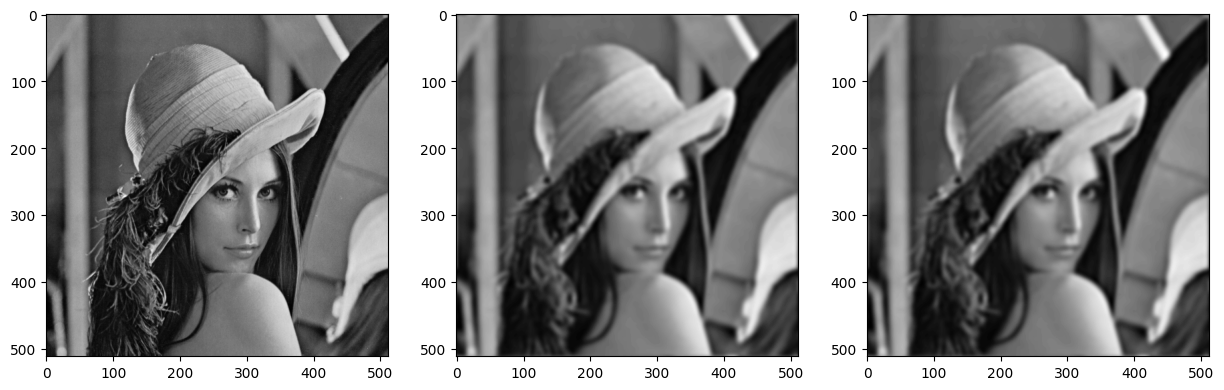

In [42]:
show_all([
    image_lena,
    window_method_filter(image_lena, lambda freq_r: (freq_r >= 0.01) & (freq_r <= 0.09545)),
    window_method_filter(image_lena, lambda freq_r: (freq_r >= 0.09520) & (freq_r <= 0.09545)),
])